In [1]:
import torch
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import psycopg2
import matplotlib.pyplot as plt
import math

/Users/konstantinos/Desktop/virtualenvs/codegrid/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load dataset

In [2]:
func_data = pd.read_csv('/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_funcs_all.tsv', sep='\t', header=None)

func_data = func_data.rename(columns={0:'id', 1:'func'})

pairs_file = '/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_pair_ids.pkl'
pairs_data = pd.read_pickle(pairs_file)

# Merge pairs_data and data based on "id1" and "id"
data = pairs_data.merge(func_data, left_on='id1', right_on='id', how='left')

# Rename the 'func' column to 'func1'
data.rename(columns={'func': 'func1'}, inplace=True)

# Drop the 'id' column (if you want to remove it)
data.drop('id', axis=1, inplace=True)

# Merge again for the second function (func2) based on "id2" and "id"
data = data.merge(func_data, left_on='id2', right_on='id', how='left')

# Rename the 'func' column to 'func2'
data.rename(columns={'func': 'func2'}, inplace=True)

# Drop the 'id' column (if you want to remove it)
data.drop('id', axis=1, inplace=True)

# Keep only semantic clones
data = pd.concat([data[data['label']==0], data[data['label']==4]])

In [3]:
data

,id1,id2,label,func1,func2
77535,21392041,23677115,0,public RegisterableChannel getChannel(...,"\tpublic static void copyFile2(File srcFile, F..."
77536,7326867,23677118,0,void doOpenUserGuideUrl(boolean online) {\...,"\tpublic static void copyFile5(File srcFile, F..."
77537,9360918,23677115,0,@Override\n public void onSucce...,"\tpublic static void copyFile2(File srcFile, F..."
77538,513859,23677115,0,public void writeInput(File inputFile) {\n...,"\tpublic static void copyFile2(File srcFile, F..."
77539,9706513,23677115,0,public synchronized SocketChannel getChann...,"\tpublic static void copyFile2(File srcFile, F..."
...,...,...,...,...,...
57530,9884136,23677117,4,private void doAddPresence(AddPresence msg...,"\tpublic static void copyFile4(File srcFile, F..."
57531,7906813,23677116,4,private void refreshLayout() {\n fo...,"\tpublic static void copyFile3(File srcFile, F..."
57532,2933758,23677116,4,public void restoreAllChannelsToInitDelay(...,"\tpublic static void copyFile3(File srcFile, F..."
57533,18322909,23677111,4,@Override\n public void run() {\n ...,\tpublic static String downloadWebpage1(String...


In [4]:
# Database connection parameters
db_params = {
    "host": "localhost",        # Replace with your PostgreSQL host
    "database": "bcb",      # Replace with your database name
    "user": "konstantinos",        # Replace with your username
    "password": "1234" # Replace with your password
}

# Establish a database connection
conn = psycopg2.connect(**db_params)

In [5]:
functionalities_sql = pd.read_sql_query("SELECT * FROM functionalities", conn)

/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_92929/697513364.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  functionalities_sql = pd.read_sql_query("SELECT * FROM functionalities", conn)


In [6]:
# Replace 'your_schema' and 'your_table' with the actual schema and table names
query = """
    SELECT * FROM clones;
"""

# Fetch data from the clones table into a Pandas DataFrame
clones_df = pd.read_sql_query(query, conn)


# Replace 'your_schema' and 'your_table' with the actual schema and table names
query = """
    SELECT * FROM false_positives;
"""

# Fetch data from the clones table into a Pandas DataFrame
false_clones_df = pd.read_sql_query(query, conn)

/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_92929/2828375149.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clones_df = pd.read_sql_query(query, conn)
/var/folders/j9/k05ysrr550d9bhp1ns50p1hm0000gn/T/ipykernel_92929/2828375149.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  false_clones_df = pd.read_sql_query(query, conn)


In [8]:
data.head()

,id1,id2,label,func1,func2
77535,21392041,23677115,0,public RegisterableChannel getChannel(...,"\tpublic static void copyFile2(File srcFile, F..."
77536,7326867,23677118,0,void doOpenUserGuideUrl(boolean online) {\...,"\tpublic static void copyFile5(File srcFile, F..."
77537,9360918,23677115,0,@Override\n public void onSucce...,"\tpublic static void copyFile2(File srcFile, F..."
77538,513859,23677115,0,public void writeInput(File inputFile) {\n...,"\tpublic static void copyFile2(File srcFile, F..."
77539,9706513,23677115,0,public synchronized SocketChannel getChann...,"\tpublic static void copyFile2(File srcFile, F..."


In [9]:
clones_df.head()

,function_id_one,function_id_two,functionality_id,type,syntactic_type,similarity_line,similarity_token,min_size,max_size,min_pretty_size,max_pretty_size,min_judges,min_confidence,min_tokens,max_tokens,internal
0,647224,13563706,4,tagged-tagged,3,0.053333,0.113567,18,150,20,150,1,1,181,1312,False
1,13563706,17930256,4,tagged-tagged,3,0.100000,0.192835,39,150,39,150,1,1,348,1312,False
2,1458629,13563706,4,tagged-tagged,3,0.080000,0.113567,27,150,27,150,1,1,193,1312,False
3,13563706,22602225,4,tagged-tagged,3,0.033333,0.070884,11,150,12,150,1,1,112,1312,False
4,8273323,13563706,4,tagged-tagged,3,0.013333,0.035061,6,150,6,150,1,1,49,1312,False


In [10]:
clones_data = data[data['label']==4]
false_clones_data = data[data['label']==0]

In [13]:
clones_data.head()

,id1,id2,label,func1,func2
37535,2279291,7895612,4,public static String encrypt(String plainT...,public final String encrypt(String input) ...
37536,10654982,17444336,4,public static String getEncryptedPassword(...,public static synchronized String encrypt(...
37537,6305269,14770729,4,"protected void copyFile(File sourceFile, F...","public static boolean joinFiles(File dest,..."
37538,3621790,7386971,4,private String sha1(String s) {\n S...,public String hash(String senha) {\n ...
37539,10828162,21393871,4,public static String loadURLToString(Strin...,public String call() throws Exception {\n ...


In [11]:
import math

### True clones

In [12]:
clones_df = clones_df.rename(columns={"function_id_one": "id1", "function_id_two": "id2"})

In [15]:
clones_merged = pd.merge(clones_data, clones_df[['id1', 'id2', 'functionality_id']], on=['id1', 'id2'], how='left')

In [16]:
clones_merged

,id1,id2,label,func1,func2,functionality_id
0,2279291,7895612,4,public static String encrypt(String plainT...,public final String encrypt(String input) ...,3.0
1,10654982,17444336,4,public static String getEncryptedPassword(...,public static synchronized String encrypt(...,3.0
2,6305269,14770729,4,"protected void copyFile(File sourceFile, F...","public static boolean joinFiles(File dest,...",4.0
3,3621790,7386971,4,private String sha1(String s) {\n S...,public String hash(String senha) {\n ...,3.0
4,10828162,21393871,4,public static String loadURLToString(Strin...,public String call() throws Exception {\n ...,2.0
...,...,...,...,...,...,...
20008,9884136,23677117,4,private void doAddPresence(AddPresence msg...,"\tpublic static void copyFile4(File srcFile, F...",NaN
20009,7906813,23677116,4,private void refreshLayout() {\n fo...,"\tpublic static void copyFile3(File srcFile, F...",NaN
20010,2933758,23677116,4,public void restoreAllChannelsToInitDelay(...,"\tpublic static void copyFile3(File srcFile, F...",NaN
20011,18322909,23677111,4,@Override\n public void run() {\n ...,\tpublic static String downloadWebpage1(String...,NaN


In [67]:
for i in range(len(clones_data)):
    if i%100 == 0:
        print(i)
    id1 = clones_merged['id1'].iloc[i]
    id2 = clones_merged['id2'].iloc[i]
    idx = np.array(clones_df['id1']==id1) & np.array(clones_df['id2']==id2)
    if sum(idx) > 1:
        print("Two fcn ids:")
        print(i)
    if sum(idx) <1:
        print("No fcn id:")
        print(i)

0
100
200
300
400
Two fcn ids:
455
Two fcn ids:
456
500
600
700
800
900
1000
1100
1200


KeyboardInterrupt: 

In [62]:
i

455

In [63]:
clones_merged.iloc[i]

id1                                                          12783713
id2                                                          16583451
label                                                               4
func1                   @Override\n    public void sendErrorMessag...
func2                   private static void setEnvEntry(File fromE...
functionality_id                                                  4.0
Name: 455, dtype: object

In [17]:
clones_df[np.array(clones_df['id1']==12783713) & np.array(clones_df['id2']==16583451)]

,id1,id2,functionality_id,type,syntactic_type,similarity_line,similarity_token,min_size,max_size,min_pretty_size,max_pretty_size,min_judges,min_confidence,min_tokens,max_tokens,internal
1939738,12783713,16583451,4,tagged-tagged,3,0.32,0.694581,24,25,24,25,1,1,196,203,False
5574562,12783713,16583451,30,tagged-tagged,3,0.32,0.694581,24,25,24,25,1,1,196,203,False


In [18]:
clones_data[np.array(clones_data['id1']==19152293) & np.array(clones_data['id2']==23677145)]

,id1,id2,label,func1,func2
57534,19152293,23677145,4,public static void main(String args[]) thr...,\tpublic static <T extends Comparable<T>> void...


In [19]:
# This is marked as non-clone in the SQL
clones_df[np.array(clones_df['id1']==19152293) & np.array(clones_df['id2']==23677145)]

,id1,id2,functionality_id,type,syntactic_type,similarity_line,similarity_token,min_size,max_size,min_pretty_size,max_pretty_size,min_judges,min_confidence,min_tokens,max_tokens,internal


In [20]:
clones_merged = clones_merged.drop_duplicates(subset=['id1', 'id2'])
# Step 2: Drop rows where 'functionality_id' is NaN
clones_merged = clones_merged.dropna(subset=['functionality_id'])

In [21]:
clones_merged

,id1,id2,label,func1,func2,functionality_id
0,2279291,7895612,4,public static String encrypt(String plainT...,public final String encrypt(String input) ...,3.0
1,10654982,17444336,4,public static String getEncryptedPassword(...,public static synchronized String encrypt(...,3.0
2,6305269,14770729,4,"protected void copyFile(File sourceFile, F...","public static boolean joinFiles(File dest,...",4.0
3,3621790,7386971,4,private String sha1(String s) {\n S...,public String hash(String senha) {\n ...,3.0
4,10828162,21393871,4,public static String loadURLToString(Strin...,public String call() throws Exception {\n ...,2.0
...,...,...,...,...,...,...
18408,19121580,19395766,4,public static String toMd5(String s) {\n ...,public static String encodePassword(String...,3.0
18409,4774514,9024096,4,protected synchronized String encryptThis(...,public static final String enCode(String a...,3.0
18410,6527977,10878062,4,"public static void copy(File in, File out)...","public static void copy(File source, File ...",4.0
18411,9399634,14024978,4,protected static String fileName2md5(Strin...,public static final String generate(String...,3.0


### False clones

In [22]:
false_clones_df = false_clones_df.rename(columns={"function_id_one": "id1", "function_id_two": "id2"})

In [23]:
false_clones_merged = pd.merge(false_clones_data, false_clones_df[['id1', 'id2', 'functionality_id']], on=['id1', 'id2'], how='left')

In [25]:
false_clones_merged

,id1,id2,label,func1,func2,functionality_id
0,21392041,23677115,0,public RegisterableChannel getChannel(...,"\tpublic static void copyFile2(File srcFile, F...",4
1,7326867,23677118,0,void doOpenUserGuideUrl(boolean online) {\...,"\tpublic static void copyFile5(File srcFile, F...",4
2,9360918,23677115,0,@Override\n public void onSucce...,"\tpublic static void copyFile2(File srcFile, F...",4
3,513859,23677115,0,public void writeInput(File inputFile) {\n...,"\tpublic static void copyFile2(File srcFile, F...",4
4,9706513,23677115,0,public synchronized SocketChannel getChann...,"\tpublic static void copyFile2(File srcFile, F...",4
...,...,...,...,...,...,...
19995,20502118,23677111,0,public List<BlockObject> allBlock() throws...,\tpublic static String downloadWebpage1(String...,2
19996,1468160,23677115,0,private void writeResponse(MessageEvent e)...,"\tpublic static void copyFile2(File srcFile, F...",4
19997,8232818,23677118,0,public void playerLogout(int playerId) {\n...,"\tpublic static void copyFile5(File srcFile, F...",4
19998,98304,23677118,0,public void readMESHTreeFileIntoDB() {\n ...,"\tpublic static void copyFile5(File srcFile, F...",4


In [26]:
false_clones_merged = false_clones_merged.drop_duplicates(subset=['id1', 'id2'])
print(len(false_clones_merged))
# Step 2: Drop rows where 'functionality_id' is NaN
false_clones_merged = false_clones_merged.dropna(subset=['functionality_id'])
print(len(false_clones_merged))

20000
20000


In [86]:
# false_clones_merged = false_clones_merged.head(len(clones_merged))

In [27]:
data = pd.concat([clones_merged, false_clones_merged])

In [29]:
data.groupby('functionality_id').size()

functionality_id
2.0      4532
3.0      7650
4.0     22888
6.0       365
7.0      1536
8.0        10
9.0        82
10.0     1336
30.0        1
dtype: int64

In [98]:
data.to_pickle('/Users/konstantinos/Desktop/Clone Generalization/binary files/bcb_1vsAll/bcb_v2_sampled.pickle')

In [90]:
data['func1'].iloc[0]

'    public static String encrypt(String plainText) throws Exception {\n        MessageDigest md = null;\n        try {\n            md = MessageDigest.getInstance("MD5");\n        } catch (NoSuchAlgorithmException e) {\n            throw new Exception(e.getMessage());\n        }\n        try {\n            md.update(plainText.getBytes("UTF-8"));\n        } catch (UnsupportedEncodingException e) {\n            throw new Exception(e.getMessage());\n        }\n        byte raw[] = md.digest();\n        String hash = (new BASE64Encoder()).encode(raw);\n        return hash;\n    }\n'

In [91]:
t = data.apply(lambda x: str(x['func1']).strip().startswith('public static void copyFile') and str(x['func2']).strip().startswith('public static void copyFile'), axis=1)


In [92]:
t = data.apply(lambda x: str(x['func1']).strip()[0:280] == str(x['func2']).strip()[0:280], axis=1)


In [93]:
i = 0
print(data[t]['func1'].iloc[i])
print(data[t]['func2'].iloc[i])

    public static void copyFiles(String strPath, String dstPath) throws IOException {
        File src = new File(strPath);
        File dest = new File(dstPath);
        if (src.isDirectory()) {
            dest.mkdirs();
            String list[] = src.list();
            for (int i = 0; i < list.length; i++) {
                String dest1 = dest.getAbsolutePath() + File.separatorChar + list[i];
                String src1 = src.getAbsolutePath() + File.separatorChar + list[i];
                copyFiles(src1, dest1);
            }
        } else {
            FileInputStream fin = new FileInputStream(src);
            FileOutputStream fout = new FileOutputStream(dest);
            int c;
            while ((c = fin.read()) >= 0) fout.write(c);
            fin.close();
            fout.close();
        }
    }

    public static void copyFiles(String strPath, String dstPath) throws IOException {
        File src = new File(strPath);
        File dest = new File(dstPath);
        if (s

In [94]:
print(data[t]['func2'].iloc[2])
print(data[t]['func2'].iloc[1])

IndexError: single positional indexer is out-of-bounds

In [95]:
data['func1'].iloc[0]

'    public static String encrypt(String plainText) throws Exception {\n        MessageDigest md = null;\n        try {\n            md = MessageDigest.getInstance("MD5");\n        } catch (NoSuchAlgorithmException e) {\n            throw new Exception(e.getMessage());\n        }\n        try {\n            md.update(plainText.getBytes("UTF-8"));\n        } catch (UnsupportedEncodingException e) {\n            throw new Exception(e.getMessage());\n        }\n        byte raw[] = md.digest();\n        String hash = (new BASE64Encoder()).encode(raw);\n        return hash;\n    }\n'

In [96]:
data[data['id1']==11372191]

,id1,id2,label,func1,func2,functionality_id_x,functionality_id_y
15711,11372191,23677117,0,protected InnerZipStreamDataNode(String pa...,"\tpublic static void copyFile4(File srcFile, F...",4.0,4


In [39]:
false_clones_df

,id1,id2,functionality_id,type,similarity_line,similarity_token,syntactic_type,min_judges,min_confidence
0,772874,23677215,39,sample-tagged,0.011658,0.014614,3,3,1
1,2061557,23677215,39,sample-tagged,0.114286,0.385650,3,1,1
2,2141807,23677215,39,sample-tagged,0.114286,0.388889,3,1,1
3,993834,23677215,39,sample-tagged,0.041420,0.068041,3,3,3
4,1150035,23677214,39,sample-tagged,0.043478,0.045147,3,3,3
...,...,...,...,...,...,...,...,...,...
279027,2906686,23677214,39,sample-tagged,0.363636,0.553846,3,1,1
279028,1181597,23677214,39,sample-tagged,0.081081,0.196172,3,3,1
279029,606245,23677214,39,sample-tagged,0.115385,0.139706,3,3,3
279030,2636728,23677215,39,sample-tagged,0.063492,0.202756,3,1,1


In [45]:
data

,id1,id2,label,func1,func2,functionality_id
0,2279291,7895612,4,public static String encrypt(String plainT...,public final String encrypt(String input) ...,3.0
1,10654982,17444336,4,public static String getEncryptedPassword(...,public static synchronized String encrypt(...,3.0
2,6305269,14770729,4,"protected void copyFile(File sourceFile, F...","public static boolean joinFiles(File dest,...",4.0
3,3621790,7386971,4,private String sha1(String s) {\n S...,public String hash(String senha) {\n ...,3.0
4,10828162,21393871,4,public static String loadURLToString(Strin...,public String call() throws Exception {\n ...,2.0
...,...,...,...,...,...,...
19995,20502118,23677111,0,public List<BlockObject> allBlock() throws...,\tpublic static String downloadWebpage1(String...,2.0
19996,1468160,23677115,0,private void writeResponse(MessageEvent e)...,"\tpublic static void copyFile2(File srcFile, F...",4.0
19997,8232818,23677118,0,public void playerLogout(int playerId) {\n...,"\tpublic static void copyFile5(File srcFile, F...",4.0
19998,98304,23677118,0,public void readMESHTreeFileIntoDB() {\n ...,"\tpublic static void copyFile5(File srcFile, F...",4.0


In [46]:
len(clones_merged)

18400

In [55]:
# Create a dictionary mapping function_id_one to functionality_id for faster lookups
# functionality_id_mapping11 = clones_df.groupby('function_id_one')['functionality_id'].max().to_dict()
# functionality_id_mapping12 = clones_df.groupby('function_id_two')['functionality_id'].max().to_dict()
functionality_id_mapping11 = clones_df.groupby('id1')['functionality_id'].max().to_dict()
functionality_id_mapping12 = clones_df.groupby('id2')['functionality_id'].max().to_dict()
functionality_id_mapping1 = functionality_id_mapping11 | functionality_id_mapping12


# functionality_id_mapping21 = false_clones_df.groupby('function_id_one')['functionality_id'].max().to_dict()
# functionality_id_mapping22 = false_clones_df.groupby('function_id_two')['functionality_id'].max().to_dict()
functionality_id_mapping21 = false_clones_df.groupby('id1')['functionality_id'].max().to_dict()
functionality_id_mapping22 = false_clones_df.groupby('id2')['functionality_id'].max().to_dict()
functionality_id_mapping2 = functionality_id_mapping21 | functionality_id_mapping22

# Use map to efficiently get functionality_ids based on function_id
functionality_ids1 = data['id1'].map(functionality_id_mapping1).tolist()[:len(clones_merged)]
functionality_ids2 = data['id1'].map(functionality_id_mapping2).tolist()[len(clones_merged):]

In [56]:
for (i,x) in enumerate(functionality_ids1):
    if math.isnan(x):
        try:
            functionality_ids1[i] =  functionality_id_mapping1[data['id1'].iloc[i]]
        except:
            functionality_ids1[i] =  functionality_id_mapping1[data['id2'].iloc[i]]



In [60]:
functionality_ids = functionality_ids1 + functionality_ids2

In [61]:
set(functionality_ids1)

{2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 10.0, 22.0, 30.0, 33.0, 37.0, 43.0}

In [64]:
set(functionality_ids2)

{2.0,
 3.0,
 4.0,
 6.0,
 7.0,
 9.0,
 10.0,
 14.0,
 18.0,
 22.0,
 25.0,
 26.0,
 27.0,
 28.0,
 30.0,
 33.0,
 37.0,
 39.0,
 43.0,
 45.0}

In [62]:
set(functionality_ids)

{2.0,
 3.0,
 4.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 14.0,
 18.0,
 22.0,
 25.0,
 26.0,
 27.0,
 28.0,
 30.0,
 33.0,
 37.0,
 39.0,
 43.0,
 45.0}

In [63]:
len(set(functionality_ids))

21

In [65]:
functionality_names = [functionalities_sql['name'][functionalities_sql['id'] == x] for x in set(functionality_ids)]

In [66]:
functionalities_sql = functionalities_sql.sort_values('id')

In [67]:
functionalities_sql

,name,description,id,search_heuristic
0,Download From Web,Downloads file from http link.,2,(openStream AND URL) OR (openConnection AND UR...
1,Secure Hash,1. Generate secure hash in binary format. 2. ...,3,.*\.\s*digest\s*\(.*
2,Copy File,Copies a file.,4,[getChannel] OR [transferFrom] OR [FileUtils.c...
3,Decompress zip archive.,"1. Retrieve a zip archive (from disk, internet...",5,Pattern#1: .*\.\s*getNext((Zip)|)Entry\s*\(\s*...
4,Connect to FTP Server,1 - Connect to the FTP server. 2 - Log in wit...,6,\.\s*connect\s*\( AND \.\s*login\s*\(
5,Bubble Sort Array,Sorts an array of values using bubble sort.,7,[a-z]\[[a-z]\] = [a-z]\[[a-z]+1\]
34,Setup SGV,1 - Create ScrollingGraphicalViewer object. 2 ...,8,ScrollingGraphicalViewer
33,Setup SGV Event Handler,"1-Create scrollinggraphicalviewer, 2-Add liste...",9,GraphicalVeiwer
6,Execute update and rollback.,1 - Execute a database update. 2 - Rollback (...,10,executeUpdate\s*\( AND rollback\s*\(\s*\)
7,Initialize Java Eclipse Project.,1-Get eclipse project (create or receive). 2-...,11,setNatureIds AND setOutputLocation AND setRawC...


# BCB v2 sampled - BF

In [68]:
from tqdm import tqdm
from gensim.models import Word2Vec
import time
import pandas as pd
import pickle
from tqdm import tqdm
from gensim.models import Word2Vec, KeyedVectors
import torch
import torch.multiprocessing
import sys
from tqdm import tqdm
from gensim.models import Word2Vec
import torch
import torch.multiprocessing
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
import sys
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
sys.path.append('../utilities-equal-functionalities') # Cluster
sys.path.append('../utilities')# Mac

from bcb_1vsAll_utilities import get_functionality_data


In [69]:
cache_dir   = '/Users/konstantinos/Desktop/Clone Generalization-100/binary files/bcb_1vsAll/' # my Mac

max_rows_per_functionality = 100

### Load BCB data
data_bcb = get_functionality_data(max_rows_per_functionality)

Loaded data_pairs_all_100.pickle from cache...


In [70]:
data_bcb

,code1,code2,label,functionality_id
0,"public TVRageShowInfo (String xmlShowName, Str...",public LinkedList < NameValuePair > getQuestio...,1,2
1,public static String get (String strUrl) {\n ...,public boolean saveVideoXMLOnWebserver () {\n ...,1,2
2,public static void doVersionCheck (View view) ...,private void fetchTree () throws IOException {...,1,2
3,public static void doVersionCheck (View view) ...,public static void main (String [] args) {\n ...,1,2
4,public static void doVersionCheck (View view) ...,private void init (URL url) {\n frame = new...,1,2
...,...,...,...,...
5853,public void mergeAndStampPdf (boolean resetSta...,public static void main (String [] args) {\n ...,0,45
5854,public static void main (String [] args) {\n ...,public static void main (String [] args) {\n ...,0,45
5855,public static void concatPDFs (List < CustomPd...,public static void main (String [] args) {\n ...,0,45
5856,public static void main (String [] args) {\n ...,public static void main (String [] args) {\n ...,0,45


In [71]:
f = data_bcb['functionality_id']

# Plot

In [72]:
(sum(np.array(functionality_ids) == 2) +sum(np.array(functionality_ids) == 3) + sum(np.array(functionality_ids) == 4)) /len(functionality_ids)

0.90921875

In [73]:
(sum(np.array(f) == 2) +sum(np.array(f) == 3) + sum(np.array(f) == 4)) /len(functionality_ids)

0.015625

In [74]:
from collections import Counter

In [75]:
counter1 = Counter(f)

In [76]:
counter2 = Counter(functionality_ids)

In [77]:
x1 = []
x2 = []
for fcn in functionalities_sql['id']:
    if fcn in counter1.keys():
        x1.append(counter1[fcn])
    else:
        x1.append(0)
        
    if fcn in counter2.keys():
        x2.append(counter2[fcn])
    else:
        x2.append(0)

In [109]:
d = pd.DataFrame({'fcn_id':functionalities_sql['id'], 'fcn_name':functionalities_sql['name'], 'x1':x1, 'x2':x2})

In [110]:
d = d.sort_values('x2', ascending=False)

In [111]:
d = d[(d['x1']>0) | (d['x2']>0)]

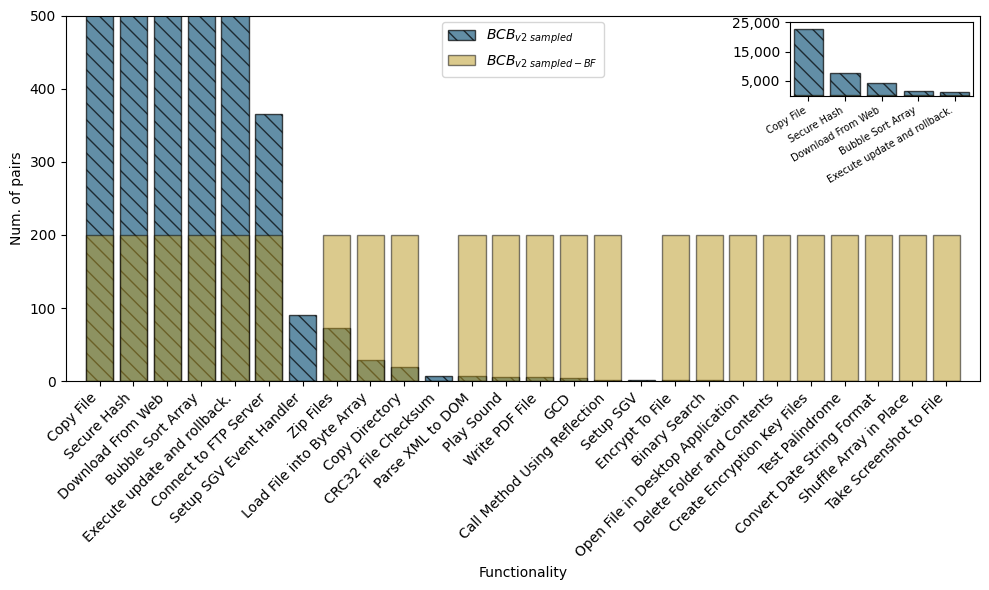

In [117]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

plt.figure(figsize=(10, 6))

# Plot the second histogram with a lower opacity, diagonal stripe fill pattern, and wider bars
plt.bar(range(len(d)), d['x2'], alpha=0.7, label=r'${BCB_{v2 \ sampled}}$', color='#1f5f80', hatch='\\\\', edgecolor='black')


# Plot the first histogram with a higher opacity, striped fill pattern, and narrower bars
plt.bar(range(len(d)), d['x1'], alpha=0.5, label=r'${BCB_{v2 \ sampled - BF}}$', color='#b8961d', edgecolor='black')


plt.xlabel('Functionality')
plt.ylabel('Num. of pairs')
plt.xticks(range(len(d)), d['fcn_name'], rotation=45, ha='right')
plt.ylim([0,500])
plt.xlim([-1,len(d)])
plt.legend(loc='upper center')

# Add a title and adjust the layout to fit a prestigious machine learning conference style
#plt.title('Number of pairs (clone and non-clone) in each functionality', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))


# Create an inset (zoomed-in) plot for positions 2 and 3
ax_inset = inset_axes(plt.gca(), width="20%", height="20%", loc=1)
# Plot the second histogram with a lower opacity, diagonal stripe fill pattern, and wider bars
plt.bar(range(len(d)), d['x2'], alpha=0.7, label=r'${BCB_{v2 \ sampled - BF}}$', color='#1f5f80', edgecolor='black', hatch='\\\\')

# Plot the first histogram with a higher opacity, striped fill pattern, and narrower bars
plt.bar(range(len(d)), d['x1'], alpha=0.5, label=r'${BCB_{v2 \ sampled}}$', color='#b8961d', edgecolor='black')



ax_inset.set_xlim(-0.5, 4.5)  # Focus on positions 2 and 3
ax_inset.set_ylim(0, 25000)  # Set a higher y-axis limit for the inset
ax_inset.set_xticks([0,1,2,3,4])
ax_inset.set_xticklabels(d['fcn_name'][0:5],  rotation=30, ha='right', fontsize=7)
ax_inset.set_yticks([5000,15000,25000])
ax_inset.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Formatted y-axis labels



plt.savefig('/Users/konstantinos/Desktop/Clone Generalization-100/assets/num_of_pairs_per_functionality.pdf', format='pdf')

# Show the plot
plt.show()


In [114]:
sum(d['x2']>0)

21